In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.base import clone
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# import altair as alt
import mlflow

from sklearn.metrics import  make_scorer
from lightgbm import LGBMRanker, LGBMClassifier #, __version__
from lightgbm import plot_importance


from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score
average_precision_scorer = make_scorer(average_precision_score, average='weighted')  #, average = 'weighted')
roc_auc_scorer = make_scorer(roc_auc_score, average='weighted') #average = 'weighted')



idx = pd.IndexSlice
import pylab as plt


In [2]:
# import sys
# sys.path.append('../')

# # from propmatch.mlflowcli import log_mlflow
from model import get_model
from mlflow_utils import mlflow_log_model
from utils import reduce_memory
from metrics import METRICS

/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


## Load Data

In [3]:
# data
# X = pd.read_parquet('./data/train/X.parquet')
# y = pd.read_parquet('./data/train/y.parquet').iloc[:, 0]

In [4]:
X_train = pd.read_parquet('./data/train/X_train.parquet')
y_train = pd.read_parquet('./data/train/y_train.parquet').iloc[:, 0]

In [5]:
X_val = pd.read_parquet('./data/train/Xval.parquet')
y_val = pd.read_parquet('./data/train/yval.parquet').iloc[:, 0]

In [6]:
X_train = reduce_memory(X_train)

Mem. usage decreased to 37.84 Mb (56.8%% reduction)


In [7]:
X_train.columns

Index(['spatial', 'days', 'price_pct_diff', 'partial_unit_score',
       'partial_street_score', 'same_unit', 'same_building_id', 'same_bin',
       'same_complex', 'candidates', 'same_zipcode', 'building_in_10',
       'same_unittype', 'x', 'y', 'distance', 'azimuth'],
      dtype='object')

#### Weights

In [8]:
sample_weights = np.where(y_train, 5, 1)

In [9]:
# sample_weights.mean()

## 1. Base Model

In [10]:
params = {'model__colsample_bytree': 0.5013544317317782,
 'model__min_child_samples': 51,
 'model__min_child_weight': 1e-05,
 'model__num_leaves': 21,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 5,
 'model__subsample': 0.4301443471481221
}


In [11]:
model = get_model(LGBMClassifier).set_params(**params)

In [12]:
scoring={'average_precision': average_precision_scorer,
         'roc_auc': roc_auc_scorer,
        'precision_at_85': METRICS[-1]}

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

In [14]:
# ?cross_validate

In [ ]:
wresults = {}

for weight in (1, 2, 5, 10, 15, 20, 50):
    sample_weights = np.where(y_train, weight, 1)
    metrics = cross_validate(model, X_train, y_train,
                         params = {'model__sample_weight': sample_weights},
                         cv=skf, return_train_score=False,
                         scoring=scoring)
    
    m_cols = ['test_average_precision','test_roc_auc', 'test_precision_at_85']
    r = pd.DataFrame(metrics)[m_cols].agg(['mean', 'std']).T
    wresults[weight] = r

[LightGBM] [Info] Number of positive: 2509, number of negative: 771714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 774223, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003241 -> initscore=-5.728730
[LightGBM] [Info] Start training from score -5.728730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2509, number of negative: 771714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

In [ ]:
w_metrics = pd.DataFrame({k: v['mean'] for k, v in wresults.items()}).T

In [ ]:
w_metrics

In [ ]:
w_metrics.plot()

## Validation Performance

In [ ]:
sample_weights = np.where(y_train, 5, 1)

In [ ]:
model.fit(X_train, y_train, model__sample_weight=sample_weights)
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

In [ ]:
print(f"""
On validation
- precision: {precision_score(y_val, y_pred):.4f}
- recall: {recall_score(y_val, y_pred):.4f}
""")

In [ ]:
treshold = 0.45

print(f"""
On validation, at Threshold={treshold:.2f}
- precision: {y_val[y_proba > treshold].mean():.3f}
- recall: {y_val[y_proba>treshold].sum() / y_val.sum():.3f}
""")

In [ ]:
average_precision_score(y_val, y_proba)

In [ ]:
roc_auc_score(y_val, y_proba)

## Plots

In [ ]:
plot_importance(model.steps[0][1]); 
# plot_importance(m); 

In [ ]:
fpr, tpr, _ = roc_curve(y_val, y_proba, pos_label=1)
prec, recall, _ = precision_recall_curve(y_val, y_proba, pos_label=1)

pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

### Threshold Curve

In [36]:
prec, recall, step = precision_recall_curve(y_val, y_proba, pos_label=1)

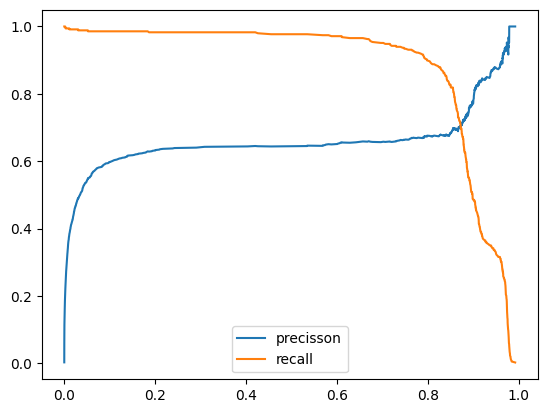

In [37]:
pd.DataFrame({'precisson':prec[:-1], 'recall':recall[:-1]}, index=step).plot();

### Calibration

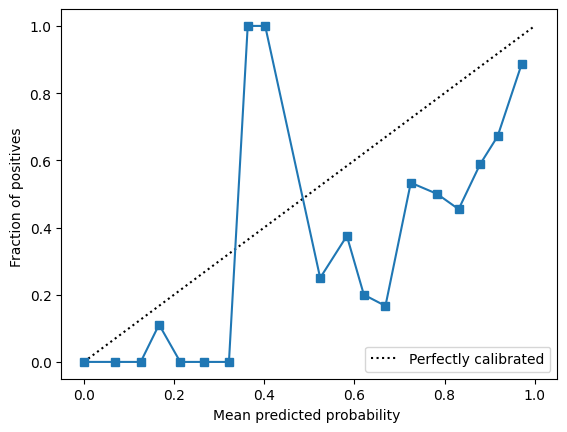

In [25]:
prob_true, prob_pred = calibration_curve(y_val, y_proba, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_proba)
disp.plot()

In [40]:
cparams = { 
        'method': 'sigmoid',
#         'method': 'isotonic',
            'ensemble':True,
            'ensemble':False,
            'cv': 4}

In [43]:
calibrated = CalibratedClassifierCV(model, **cparams)
calibrated.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2352, number of negative: 723482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 725834, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003240 -> initscore=-5.728810
[LightGBM] [Info] Start training from score -5.728810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2352, number of negative: 723482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063619 seconds.
You can set `force_row_wise=true` to remo

CalibratedClassifierCV(cv=4, ensemble=False,
                       estimator=Pipeline(steps=[('model',
                                                  LGBMClassifier(colsample_bytree=0.5013544317317782,
                                                                 min_child_samples=51,
                                                                 min_child_weight=1e-05,
                                                                 num_leaves=21,
                                                                 reg_alpha=0.1,
                                                                 reg_lambda=5,
                                                                 subsample=0.4301443471481221))]))

In [44]:
y_pred_c = calibrated.predict_proba(X_val)[:, 1]
y_c = calibrated.predict(X_val)

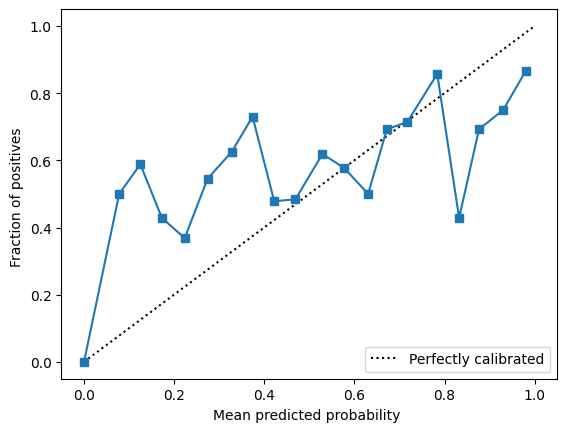

In [45]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_c, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_pred_c)
disp.plot()

In [46]:
metaflow_config = dict(
    tracking_uri='https://mlflow.production.streeteasy.cloud',
    experiment_name='expert_transaction_matching',
    model_name='expert_transaction_matching',
    tags=dict(target='matching')
)

In [ ]:
metaflow_config['run_name'] = 'binary_lbgm_bool_w'

mlflow_log_model(
    calibrated,
    X_train,
    y_train,
    metaflow_config, 
    model_metadata={'sampling':'weighted_5', },
    validation=(X_val, y_val, METRICS),
    upload_model=True
)

2024/03/29 17:33:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 17:33:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


[LightGBM] [Info] Number of positive: 2352, number of negative: 723482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 725834, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003240 -> initscore=-5.728810
[LightGBM] [Info] Start training from score -5.728810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2352, number of negative: 723482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006405 seconds.
You can set `force_row_wise=true` to remo

2024/03/29 17:34:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Failed to upload /var/folders/v2/l685f8rj7jn4flt11pny4lsr0000gq/T/tmpdg284cg9/training_roc_curve.png to streeteasy-datalake/research/mlflow/793/4b3ebb963cbf47b8b5e9ad6c9eb5af4b/artifacts/training_roc_curve.png: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied
